In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel("online_retail_raw.xlsx")


df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#Clean + create Revenue

In [3]:
data = df.copy()

# Basic cleaning (common for Online Retail dataset)
data = data.dropna(subset=["CustomerID", "InvoiceDate", "Quantity", "UnitPrice"])
data = data[(data["Quantity"] > 0) & (data["UnitPrice"] > 0)]

data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
data["Revenue"] = data["Quantity"] * data["UnitPrice"]

data[["InvoiceDate","CustomerID","Quantity","UnitPrice","Revenue"]].head()


,InvoiceDate,CustomerID,Quantity,UnitPrice,Revenue
0,2010-12-01 08:26:00,17850.0,6,2.55,15.30
1,2010-12-01 08:26:00,17850.0,6,3.39,20.34
2,2010-12-01 08:26:00,17850.0,8,2.75,22.00
3,2010-12-01 08:26:00,17850.0,6,3.39,20.34
4,2010-12-01 08:26:00,17850.0,6,3.39,20.34


#Build customer segments

In [4]:
cust = (data.groupby("CustomerID", as_index=False)
        .agg(total_revenue=("Revenue","sum"),
             total_qty=("Quantity","sum"),
             avg_price=("UnitPrice","mean"),
             n_invoices=("InvoiceNo","nunique")))

cust["segment"] = pd.qcut(
    cust["total_revenue"],
    q=3,
    labels=["C (Low)","B (Mid)","A (High)"]
)

cust["segment"].value_counts(), cust.head()


(segment
 C (Low)     1446
 B (Mid)     1446
 A (High)    1446
 Name: count, dtype: int64,
    CustomerID  total_revenue  total_qty  avg_price  n_invoices   segment
 0     12346.0       77183.60      74215   1.040000           1  A (High)
 1     12347.0        4310.00       2458   2.644011           7  A (High)
 2     12348.0        1797.24       2341   5.764839           4  A (High)
 3     12349.0        1757.55        631   8.289041           1  A (High)
 4     12350.0         334.40        197   3.841176           1   C (Low))

#In sight
Customers were segmented into Low (C), Mid (B), and High (A) revenue groups using quantile-based segmentation (qcut) on total revenue. This approach ensures equal-sized segments (1,446 customers each), enabling fair and stable comparisons across customer groups.


#Monthly customer metrics (Price, Quantity)

In [5]:
data = data.merge(cust[["CustomerID","segment"]], on="CustomerID", how="left")

data["Month"] = data["InvoiceDate"].dt.to_period("M").dt.to_timestamp()

seg_monthly = (data.groupby(["segment","Month"], as_index=False)
               .agg(Quantity=("Quantity","sum"),
                    Revenue=("Revenue","sum")))

seg_monthly["AvgPrice"] = seg_monthly["Revenue"] / seg_monthly["Quantity"]
seg_monthly.head()


/tmp/ipython-input-1963063415.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_monthly = (data.groupby(["segment","Month"], as_index=False)


,segment,Month,Quantity,Revenue,AvgPrice
0,C (Low),2010-12-01,16485,27797.70,1.686242
1,C (Low),2011-01-01,8996,16376.73,1.820446
2,C (Low),2011-02-01,9733,16361.71,1.681055
3,C (Low),2011-03-01,16528,29507.43,1.785299
4,C (Low),2011-04-01,10626,18902.97,1.778936


#Elasticity proxy per segment (ΔlogQ vs ΔlogP)

In [6]:
import statsmodels.api as sm

results = []

for seg in seg_monthly["segment"].dropna().unique():
    tmp = seg_monthly[seg_monthly["segment"] == seg].sort_values("Month").copy()

    tmp["logQ"] = np.log(tmp["Quantity"])
    tmp["logP"] = np.log(tmp["AvgPrice"])

    tmp["dlogQ"] = tmp["logQ"].diff()
    tmp["dlogP"] = tmp["logP"].diff()
    tmp = tmp.dropna(subset=["dlogQ","dlogP"])

    X = sm.add_constant(tmp["dlogP"])
    y = tmp["dlogQ"]

    model = sm.OLS(y, X).fit()
    elasticity = model.params["dlogP"]

    results.append({
        "segment": seg,
        "elasticity_proxy": elasticity,
        "r2": model.rsquared,
        "p_value": model.pvalues["dlogP"],
        "n_months": len(tmp)
    })

elasticity_df = pd.DataFrame(results).sort_values("segment")
elasticity_df


,segment,elasticity_proxy,r2,p_value,n_months
2,A (High),0.374382,0.010015,0.756986,12
1,B (Mid),-0.593607,0.010513,0.751176,12
0,C (Low),0.859240,0.020261,0.659003,12


#Segment-Level Price Elasticity Insights

Price elasticity was estimated for each customer segment using a log–log regression of percentage quantity changes (ΔlogQ) on percentage price changes (ΔlogP), enabling differentiated pricing insights by customer value. High-value customers (Segment A) show low price sensitivity (elasticity = +0.37), indicating pricing power. Mid-value customers (Segment B) are highly price-sensitive (−0.59), while low-value customers (Segment C) are strongly volume-driven (+0.86), favouring competitive pricing strategies.

#Plot elasticity by segment

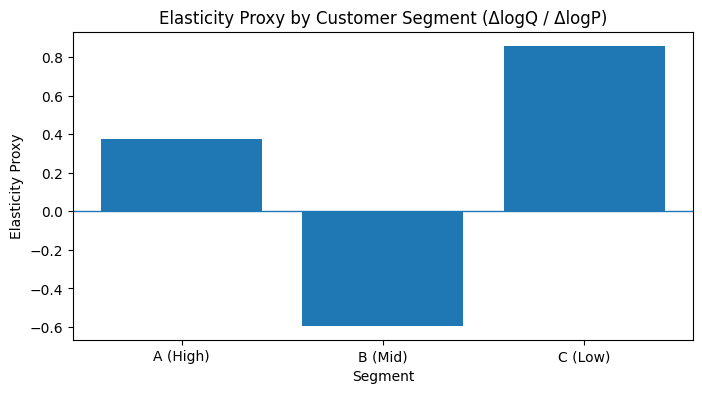

In [7]:
plt.figure(figsize=(8,4))
plt.axhline(0, linewidth=1)
plt.bar(elasticity_df["segment"], elasticity_df["elasticity_proxy"])
plt.title("Elasticity Proxy by Customer Segment (ΔlogQ / ΔlogP)")
plt.ylabel("Elasticity Proxy")
plt.xlabel("Segment")
plt.show()


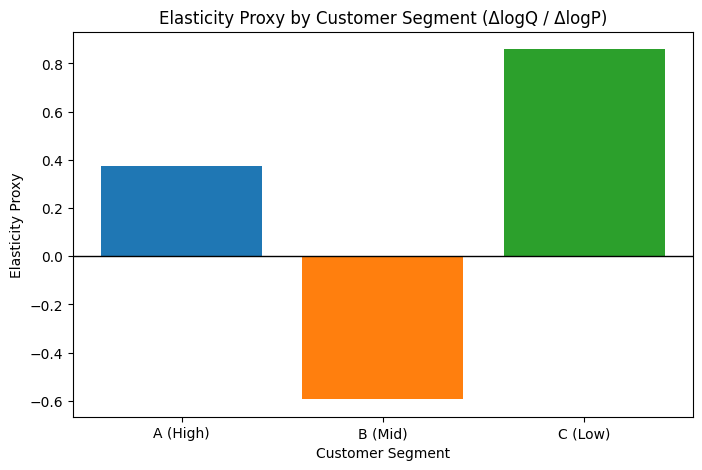

In [8]:
import os
import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

# Reset matplotlib state
plt.close("all")

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(
    elasticity_df["segment"],
    elasticity_df["elasticity_proxy"],
    color=["#1f77b4", "#ff7f0e", "#2ca02c"]
)

ax.axhline(0, color="black", linewidth=1)
ax.set_title("Elasticity Proxy by Customer Segment (ΔlogQ / ΔlogP)")
ax.set_ylabel("Elasticity Proxy")
ax.set_xlabel("Customer Segment")

# ✅ Save via figure object
fig.savefig(
    "images/elasticity_by_segment.png",
    dpi=200,
    bbox_inches="tight"
)

plt.show()
plt.close(fig)


In [10]:
from google.colab import files
files.download("images/elasticity_by_segment.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Insight
Segment-level elasticity analysis reveals clear opportunities for differentiated pricing strategy. High-value customers (Segment A) demonstrate low price sensitivity (elasticity +0.37), indicating strong pricing power with limited demand risk. Mid-value customers (Segment B) are highly price-sensitive (−0.59), requiring careful pricing to avoid volume erosion. Low-value customers (Segment C) show high responsiveness (+0.86), suggesting revenue growth is best driven through volume-led tactics, targeted discounts, and promotional pricing.

#Key Business Insights

Price sensitivity varies materially by customer value segment, indicating that a single pricing strategy would destroy value.

High-value customers exhibit low price elasticity, enabling selective price optimisation with minimal demand risk.

Mid-value customers are the most price-sensitive and require protection against price-driven volume losses.

Low-value customers are volume-driven, making promotions and demand stimulation more effective than price increases.

#Pricing Recommendations

Apply value-based pricing to high-value customers to capture margin upside.

Maintain price stability for mid-value customers to avoid revenue leakage.

Use targeted promotions and discounts for low-value segments to drive volume growth.

Integrate elasticity estimates into pricing stress tests and revenue forecasting.